In [108]:
import collections

import math

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats
from scipy.stats import skew
from scipy.stats import randint as sp_randint
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


import lightgbm as lgb


from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

## 1. Load Data

In [109]:
# convert text data in the txt file into a pandas dataframe
def get_df_review(filename='4U_Reviews.txt', encoding = "ISO-8859-1"):
    
    #map the content to dictionary
    dict_review = {'Title':[], 
                   'User Name':[], 
                   'Country':[], 
                   'Date':[],
                   'Rating':[], 
                   'Review':[], 
                   'Type Of Traveller':[], 
                   'Cabin Flown':[], 
                   'Route':[], 
                   'Date Flown':[], 
                   'Seat Comfort':[], 
                   'Cabin Staff Service':[], 
                   'Ground Service':[], 
                   'Value For Money':[], 
                   'Recommended':[]
                  }

    other_info_names = ['Type Of Traveller', 
                        'Cabin Flown', 
                        'Route', 
                        'Date Flown', 
                        'Seat Comfort', 
                        'Cabin Staff Service', 
                        'Ground Service', 
                        'Value For Money', 
                        'Recommended'
                       ]
    
    f = open(filename, "r", encoding = encoding)
    
    review_info_list = [] 
    
    for line in f:
        if line == '\n':
            #print("-----")
            #print(review_info_list)

            # get Title, User Name, Country, Date, Rating, Review
            for i, line in enumerate(review_info_list):
                # get title
                if i == 0:
                    #print('title: {}'.format(line))
                    dict_review['Title'].append(line)
                # get user name, country, date
                elif i == 1:
                    pos_start = line.find('(')
                    pos_end = line.find(')')
                    user_name = line[0:pos_start].strip()
                    country_name = line[pos_start+1:pos_end].strip()
                    date_str = line[pos_end+1:].strip()
                    #print('user name: {}'.format(user_name))
                    #print('country name: {}'.format(country_name))
                    #print('date: {}'.format(date_str))
                    dict_review['User Name'].append(user_name)
                    dict_review['Country'].append(country_name)
                    dict_review['Date'].append(date_str)
                # get rating
                elif i == 2:
                    if line.strip() == 'na':
                        rating = np.nan
                    else:
                        rating = int(line.strip())
                    #print('rating: {}'.format(rating))
                    dict_review['Rating'].append(rating)
                # get review
                elif i == 3:
                    #print('review')
                    #print(line.strip())
                    dict_review['Review'].append(line.strip())
            
            # get other information     
            for info_name in other_info_names:
                review_info = ''
                for i, line in enumerate(review_info_list):
                    pos = line.find(info_name)
                    if pos != -1:
                        review_info = line[len(info_name)+1:].strip()
                        break
                dict_review[info_name].append(review_info)

            review_info_list = [] 
        else:
            line = line.replace('\"', '')
            #print(line)
            review_info_list.append(line)


    df_review = pd.DataFrame(dict_review)
    
    # get route to and route from   
    def f_from(x):
        if x:
            return x.split()[0]
        return ''
    def f_to(x):
        if x:
            return x.split()[2]
        return ''
    df_review['Route From'] = df_review['Route'].apply(f_from)
    df_review['Route To'] = df_review['Route'].apply(f_to)
    

    return df_review
            
        

In [110]:
df_review = get_df_review()

## 2. EDA

In [111]:
df_review.head()

,Cabin Flown,Cabin Staff Service,Country,Date,Date Flown,Ground Service,Rating,Recommended,Review,Route,Seat Comfort,Title,Type Of Traveller,User Name,Value For Money,Route From,Route To
0,Economy,12345,Canada,16th October 2015,September 2015,12345,2.0,no,We flew with Germanwings (or tried to) on Sept...,Stuttgart to Amsterdam,12345,they have been unresponsive\n,Couple Leisure,Brian McNamee,12345,Stuttgart,Amsterdam
1,Economy,12345,United Kingdom,4th October 2015,September 2015,12345,3.0,no,I am less than impressed with Germanwings serv...,Hamburg to London,12345,I was refused some water\n,Solo Leisure,L Mouratidou,12345,Hamburg,London
2,Economy,12345,Germany,21st September 2015,September 2015,12345,3.0,no,Flew from Palma de Mallorca to Cologne with Ge...,PMI to CGN,12345,the service crew were friendly but nothing more\n,Couple Leisure,H Mutschler,12345,PMI,CGN
3,,12345,Germany,20th September 2015,August 2015,12345,10.0,yes,Good flight from Berlin-Tegel to London Heathr...,Berlin-Tegel to London Heathrow,12345,"no problems or delays, very friendly staff\n",Business,Oliver Numrich,12345,Berlin-Tegel,London
4,Economy,12345,Germany,14th September 2015,September 2015,12345,4.0,no,I don't get why Germanwings is always late and...,CGN to LHR,12345,I don't get why Germanwings is always late\n,Business,Andreas Huettenhoelscher,12345,CGN,LHR


In [112]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 17 columns):
Cabin Flown            127 non-null object
Cabin Staff Service    127 non-null object
Country                127 non-null object
Date                   127 non-null object
Date Flown             127 non-null object
Ground Service         127 non-null object
Rating                 114 non-null float64
Recommended            127 non-null object
Review                 127 non-null object
Route                  127 non-null object
Seat Comfort           127 non-null object
Title                  127 non-null object
Type Of Traveller      127 non-null object
User Name              127 non-null object
Value For Money        127 non-null object
Route From             127 non-null object
Route To               127 non-null object
dtypes: float64(1), object(16)
memory usage: 16.9+ KB


In [113]:
df_review.shape

(127, 17)

### 2.1 analyse target 'Recommended' 

In [114]:
df_review['Recommended'].describe()

count     127
unique      2
top        no
freq       65
Name: Recommended, dtype: object

In [115]:
df_review['Recommended'].unique()

array(['no', 'yes'], dtype=object)

In [116]:
df_review['Recommended'].isnull().sum()

0

In [117]:
# convert string to integer
def f(x):
    if x=='yes':
        return 1
    else:
        return 0
df_review['Recommended'] = df_review['Recommended'].apply(f)

In [119]:
df_review['Recommended'].describe()

count    127.000000
mean       0.488189
std        0.501840
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Recommended, dtype: float64

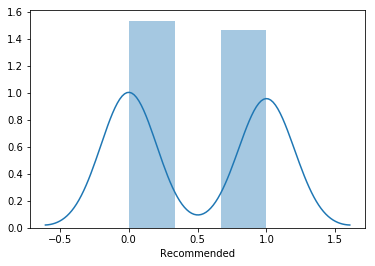

In [120]:
sns.distplot(df_review['Recommended'])

In [121]:
df_review[df_review['Recommended'] == 1].shape

(62, 17)

In [122]:
df_review[df_review['Recommended'] == 0].shape

(65, 17)

## 3. Modelling